In [1]:
!pip install librosa

You should consider upgrading via the '/home/ollie/anaconda3/bin/python -m pip install --upgrade pip' command.


In [2]:
%matplotlib inline

from IPython.display import Audio
import librosa
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

plt.rcParams['figure.figsize'] = 8, 4
plt.style.use('ggplot')

In [3]:
RATE = 16000

In [4]:
def load_signal_wav(name):
    signal, _ = librosa.load(name + '.wav', sr = RATE, mono = True)
    return signal

In [5]:
def sine_wave(freq, duration):
    return np.sin(np.arange(0, duration, 1 / RATE) * freq * 2 * np.pi) 

A440, sine wave:

In [6]:
samples_sine = sine_wave(440, 2)
Audio(samples_sine, rate = RATE)

In [7]:
# Audio synth using flute or violin sample
def mk_syth(source = 'flute'):
    assert source in ['flute', 'violin']
    samples_original = load_signal_wav(source)
    N = samples_original.shape[0]
    spectrum = sp.fftpack.fft(samples_original)
    frequencies = sp.fftpack.fftfreq(N, 1 / RATE)

    frequencies = frequencies[:N//2]
    amplitudes = np.abs(spectrum[:N//2])

    a,b = 3, 1
    plt.subplot(a, b, 1)
    plt.title('Source DFT')
    plt.specgram(samples_original, Fs = RATE);

    # ### Locating the maxima
    # To find the frequencies where such peaks are located turns out to be a little tricky: to locate the peaks the [scipy.signal.find_peaks_cwt](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks_cwt.html) needs a `widths` parameter specifing "the expected width of peaks of interest". 
    # After some trial and error, one can see that `60` is a reasonable width to get *close enough* to the actual peaks. 
    peak_indices = sp.signal.find_peaks_cwt(amplitudes, widths = (60,))
    plt.subplot(a, b, 2)

    amplitudes_maxima = list(map(lambda idx: np.max(amplitudes[idx - 10:idx + 10]), peak_indices))
    frequencies_maxima = frequencies[np.isin(amplitudes, amplitudes_maxima)]

    plt.semilogy(frequencies, amplitudes)
    plt.plot(frequencies_maxima, amplitudes_maxima, 'bx');

    samples_reconstructed = compose_sine_waves(frequencies_maxima, amplitudes_maxima, 2)
    plt.subplot(a, b, 3)
    plt.title('Synth DFT')
    plt.specgram(samples_reconstructed, Fs = RATE);
    
    return frequencies_maxima, amplitudes_maxima

In [8]:
def find_peaks(frequencies, amplitudes, width, lookaround):
    peak_indices = sp.signal.find_peaks_cwt(amplitudes, widths = (width,))
    amplitudes_maxima = list(map(lambda idx: np.max(amplitudes[idx - lookaround:idx + lookaround]), peak_indices))
    frequencies_maxima = frequencies[np.isin(amplitudes, amplitudes_maxima)]
    return frequencies_maxima, amplitudes_maxima

def compose_sine_waves(frequencies, amplitudes, duration):
    return sum(map(lambda fa: sine_wave(fa[0], 2) * fa[1], zip(frequencies, amplitudes)))

def compose_tones(freqs, decay = .5):
    freqs = sorted(freqs)
    fundamental = freqs[0]
    ratios = np.array(freqs)  / fundamental
    dampening = np.exp(-ratios * decay)
    tones = np.vstack([
        compose_sine_waves(frequencies_maxima * r, amplitudes_maxima, 2) for r in ratios]
    ) * dampening[:, None]
    return tones.sum(axis = 0)

In [9]:
rate = 16000.
duration = 2
t = np.linspace(
    0., duration, int(rate * duration))

def synth(*fs):
    """
    stack sine waves
    """
    x = np.zeros_like(t)
    for f in fs:
        x += np.sin(f * 2. * np.pi * t)
    display(Audio(x, rate=rate, autoplay=True))

In [10]:
# samples_reconstructed = compose_sine_waves(frequencies_maxima, amplitudes_maxima, 2)
# Audio(samples_reconstructed, rate = RATE)

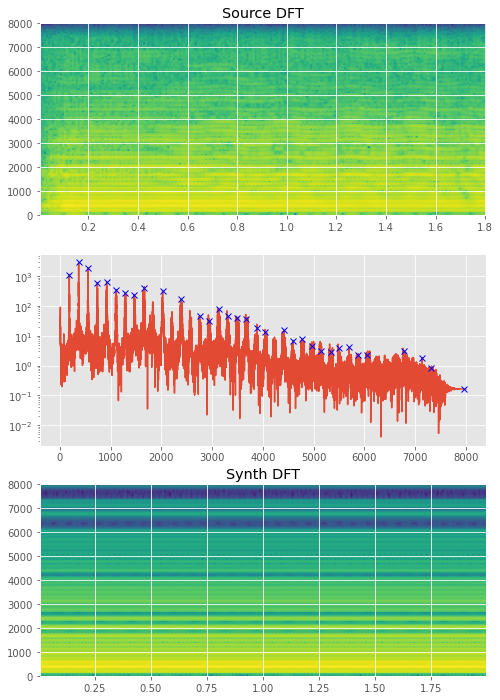

In [11]:
plt.rcParams['figure.figsize'] = 8, 12
frequencies_maxima, amplitudes_maxima = mk_syth('violin')

### A chord is an array of frequencies, which you can construct like this:

In [12]:
fD4 = 440 * 2 / 3 # violin D

## D7 chord with flattened 7th
D7 = np.array([1, 5 / 4, 3 / 2, 16 / 9]) * fD4

## without
#D7 = np.array([1, 5 / 4, 3 / 2, 9 / 5]) * fD4

D7

array([293.33333333, 366.66666667, 440.        , 521.48148148])

### Violin

In [19]:
# First argument to compose_tones is note frequencies
# Second argument is amplitude decay rate as function of frequency relatative to the fundamental.
# You might have to adjust this to make the higher notes not too loud, especially for flute
Audio(compose_tones(D7, .2), rate = RATE, autoplay = True)

### Sine waves

In [20]:
synth(*list(D7))

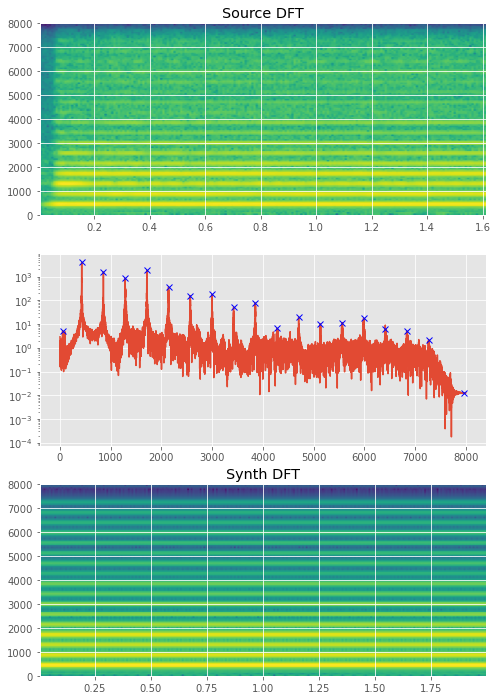

In [21]:
frequencies_maxima, amplitudes_maxima = mk_syth('flute')

### Flute

In [22]:
Audio(compose_tones(D7, 1), rate = RATE, autoplay = True)